## Letterboxd Reviews: Midsommar

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DayLocator, DateFormatter, date2num

This is a brief exercise in webscraping. I use BeautifulSoup to go through the reviews of a newly release indie horror movie, Midsommar, on a movie reviewing/social media platform, Letterboxd. I was initially interested in seeing how positive reviews from influential users prompt their followers to watch new releases. Ideally, this will be done through some kind of network time series. In the meantime, I collect information about the users that reviewed the movie and the *date* at which this was done. Luckily, Letterboxd has a diary feature which allows users to both review and log in the date at which they watched a certain movie. I therefore first collect the information of all users which reviewed Midsommar online, then go through their online diaries to retrieve the date they watched it at and the rating.

In [14]:
user_page = [] #empty results vector
date = []
rating = []
user_name = []

#getting results for a specific movie
movie_tag = "midsommar"

url = "https://letterboxd.com/film/" + movie_tag + "/ratings/" #movie url
res = requests.get(url) #request data
soup = BeautifulSoup(res.text, "lxml") 
users = soup.select(".-a40")  #returns list with all users having rated movie

for i in range(1, len(users)): #excluding 0 which contains the whole page
    #link = str("https://letterboxd.com/") + str(users[i]).split("/")[1] + "/" #creates link with username
    #book_titles[i]["href"]).replace("../../../", "") 
    #user_page.append(link) #generates functional link by getting rid of ../../../
    
    user = str(users[i]).split("/")[1]
    user_name.append(user)
    
    link = str("https://letterboxd.com/") + user + "/films/diary/decade/2010s/" #general url
    res = requests.get(link) #request data
    soup = BeautifulSoup(res.text, "lxml") 
    user_movies = soup.select("td")  #select all movies from user's page
    
    if movie_tag in str(user_movies): #if the movie has been added to user's diary
        user_date = str(user_movies).split(movie_tag)[0].split("/films/diary/for/")[-1].replace('"', '').split("/>")[0] #date y/m/d
        user_rating = str(user_movies).replace('"', '').split("type=range value=")[1].split("/>")[0] #rating out of 10
        
        date.append(user_date)
        rating.append(int(user_rating)) #makes sure ratings is numeric
    
    else: #otherwise write it down as missing value
        date.append(np.nan)
        rating.append(np.nan)

I quickly check that the web scraping was successful:

In [15]:
date[:5]

['2019/07/13', nan, nan, '2019/07/13', nan]

In [16]:
rating[:5]

[10, nan, nan, 10, nan]

After checking that the scraping went well, I create a dataframe containing all of the information I just gathered:

In [17]:
movie_reviews = pd.DataFrame({"date" : date})
movie_reviews["rating"] = rating
movie_reviews["user"] = user_name

In [18]:
movie_reviews.head()

,date,rating,user
0,2019/07/13,10.0,ladylardman
1,NaN,NaN,sarahstarlight
2,NaN,NaN,moviematt1987
3,2019/07/13,10.0,magic_kitten
4,NaN,NaN,patrickcarrico


The problem with the diary method is that not all users use it: as a result, the dataframe contains many missing values. 

I deal with this problem by creating a version of the dataframe which drops all missing values: 

In [ ]:
movie_reviews_short = movie_reviews.dropna().reset_index()
movie_reviews_short.head()

In [92]:
len(movie_reviews_short)

297

In [91]:
len(movie_reviews_short) / len(movie_reviews)

0.594

This leaves me with 60% or so of users and 300 or so data points.

The next problem I need to deal with is that my dates are, for now, just strings. Thankfully this can easily be settled using one of pandas' datetime method. Beforehand, I remove a review which was scraped improperly (does not contain a date) and must be removed:

In [28]:
for i in range(0, len(movie_reviews_short)):
    if "2019" not in movie_reviews_short['date'][i]:
        print(movie_reviews_short["index"][i])

370


In [33]:
movie_reviews_short = movie_reviews_short[movie_reviews_short["index"] != 370]

In [35]:
movie_reviews_short["date"] = pd.to_datetime(movie_reviews_short['date'])

I can move on to plotting. For this type of data, grouping reviews by date is most effective.

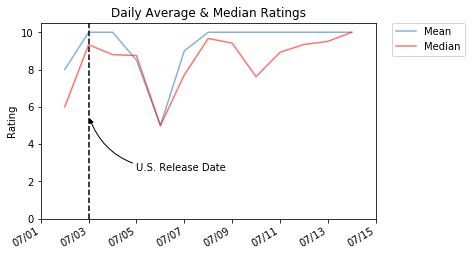

In [82]:
fig, ax = plt.subplots()

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].median().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].median(), alpha = 0.55) 
#uses a groupby method to get median review per date

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean(), alpha = 0.55,
          color = "red") 

plt.axvline("2019/07/03", color='black', linestyle='dashed', linewidth=1.5) #release date

#axis labels
ax.set_ylabel("Rating")
ax.set_title("Daily Average & Median Ratings")
ax.set_ylim([0, 10.5])
ax.set_xlim(["2019/07/01", "2019/07/15"])

#adding legend
plt.legend(["Mean", "Median"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#adding annotation
plt.annotate('U.S. Release Date', xy=("2019/07/03", 5.5), xytext=("2019/07/05", 2.55), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=110", facecolor='black')
)

#date formatting
fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%m/%d')) #displaying months only for legibility

plt.show(); 

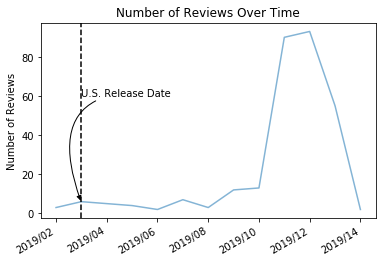

In [88]:
fig, ax = plt.subplots()
ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].count().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].count(), alpha = 0.55) 

plt.axvline("2019/07/03", color='black', linestyle='dashed', linewidth=1.5) #release date

#axis labels
ax.set_ylabel("Number of Reviews")
ax.set_title("Number of Reviews Over Time")

#adding annotation
plt.annotate('U.S. Release Date', xy=("2019/07/03", 5.5), xytext=("2019/07/03", 60), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=110", facecolor='black')
)

fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%Y/%d')) #displaying months only for legibility
plt.show(); 

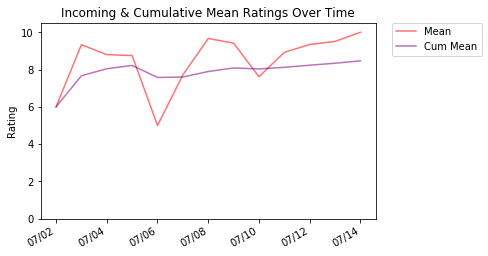

In [50]:
fig, ax = plt.subplots()

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean(), alpha = 0.55,
          color = "red") 

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().expanding().mean(), 
        alpha = 0.55, color = "purple")

#axis labels
ax.set_ylabel("Rating")
ax.set_title("Incoming & Cumulative Mean Ratings Over Time")
ax.set_ylim([0, 10.5])

#adding legend
plt.legend(["Mean", "Cum. Mean"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#date formatting
fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%m/%d')) #displaying months only for legibility

plt.show(); 

### Next Steps
In the near future, I'll start collecting the number of followers of each one of these users and the number of people they follow. Then I will map their network and hopefully be able to show how scores/viewings "spread" across users.